In [10]:
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tensorflow.keras.datasets import cifar10

## Standard BOW Pipeline For Computer Visison

### Some Information about Dataset

In [11]:
(trainImages, trainLabels), (testImages, testLabels) = cifar10.load_data()

In [12]:
print(f"Whole Train Data Image shape = {trainImages.shape}")
print(f"Single Train Image shape = {trainImages[0].shape}")
print(f"Labels  = {set(trainLabels.ravel())}")
print(f"Train Data Size = {trainImages.shape[0]}")
print(f"Test Data Size = {testImages.shape[0]}")

Whole Train Data Image shape = (50000, 32, 32, 3)
Single Train Image shape = (32, 32, 3)
Labels  = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}
Train Data Size = 50000
Test Data Size = 10000


In [13]:
labelsMap = {0:	"airplane",
1	: "automobile",
2	: "bird",
3	: "cat",
4	: "deer",
5	: "dog",
6	: "frog",
7	: "horse",
8	: "ship",
9	: "truck"}

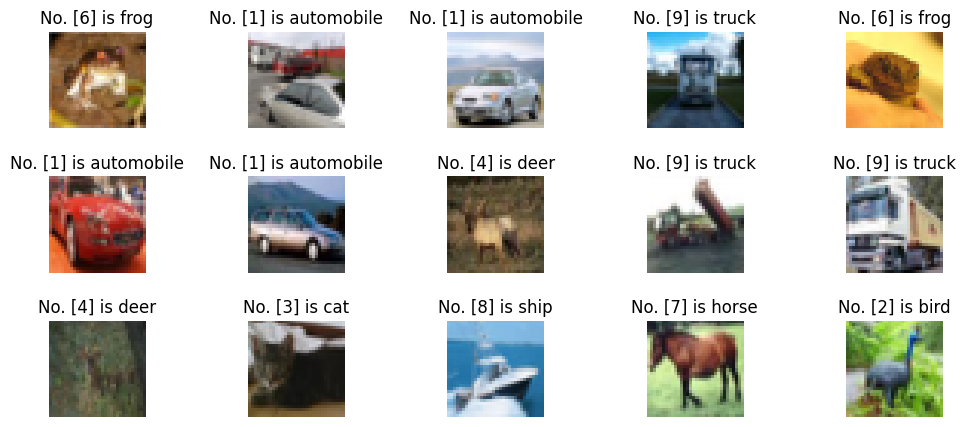

In [14]:
rows = 3
colums = 5
f, ax = plt.subplots(rows, colums, figsize=(12, 5), gridspec_kw={'wspace':0.5, 'hspace':0.5}, squeeze=True)

for r in range(rows):
  for c in range(colums):
    image_ind = r * 5 - c
    ax[r,c].axis("off")
    ax[r,c].imshow(trainImages[image_ind], cmap='gray')
    ax[r,c].set_title(f"No. {trainLabels[image_ind]} is {labelsMap[trainLabels.ravel()[image_ind]]}")
plt.show()


## Standard Bag Of Words Pipeline

## Dictionary Learning

In [15]:
def prepareImage(imageRaw):
    # Convert Images to Grayscale
    images = [cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) for img in imageRaw]
    return images

In [16]:
def extractFeatures(images):
    features = []
    sift = cv2.SIFT_create()

    for img in tqdm(images):
        keypoints, descriptors = sift.detectAndCompute(img, None)
        # check if decriptors are not null
        if descriptors is not None :
          features.extend(descriptors)
    return np.array(features)

In [17]:
def buildVisualDictionary(features, dictionary_size):
    # Create kmean cluster using dictionary_size as n_clusters
    kmeans = KMeans(dictionary_size)
    # fit the model
    kmeans.fit(features)
    # assign kmean centroids to visual_words
    visual_words = kmeans.cluster_centers_
    return visual_words

In [18]:
images = prepareImage(trainImages)
features = extractFeatures(images)
dictionary_size = 30
visual_dictionary = buildVisualDictionary(features, dictionary_size)

100%|██████████| 50000/50000 [00:50<00:00, 999.90it/s] 
c:\Users\attam\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


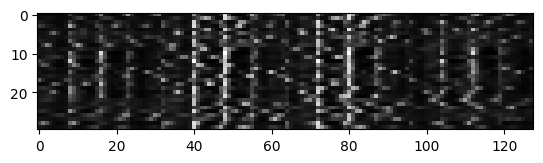

In [19]:
plt.imshow(visual_dictionary,cmap = "gray");

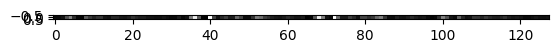

In [20]:
plt.imshow(visual_dictionary[5].reshape((1,128)),cmap="gray");

(array([81., 21.,  2., 10.,  5.,  1.,  2.,  2.,  2.,  2.]),
 array([  4.84892464,  17.67588425,  30.50284195,  43.32980347,
         56.15676117,  68.98371887,  81.81067657,  94.63763428,
        107.46459961, 120.29155731, 133.11851501]),
 <BarContainer object of 10 artists>)

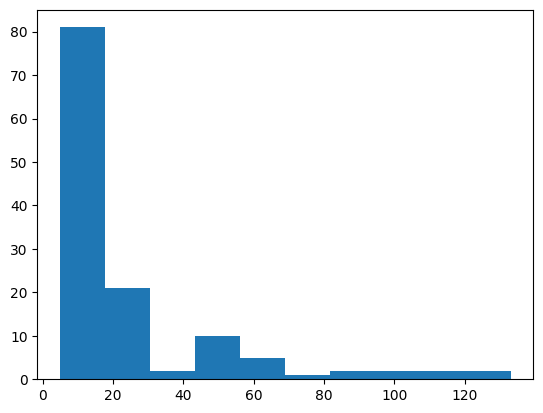

In [21]:
plt.hist(visual_dictionary[20])

## Encode

In [22]:
def encode_images(images,labels, visual_dictionary):
    bow_vectors = []
    encodedLabel = []
    sift = cv2.SIFT_create()

    for i in tqdm(range(len(images))):
        # Detect keypoints and compute descriptors using the SIFT detector
        keypoints, descriptors = sift.detectAndCompute(images[i], None)
        # Check if descriptors are not null
        if descriptors is not None:
          # intialize a zero vector to carry features
            bow_vector = np.zeros((len(images),))

            # For each descriptor in the image, find the closest visual word in the dictionary
            for d in descriptors:
                # Find the index of the closest visual word use norm to get shortest distance
                idx = np.argmin(np.linalg.norm(d-visual_dictionary))
                # Increment the corresponding bin in the BoW vector
                bow_vector[idx] += 1

            # Append the BoW vector for the current image to the list as well as labels
            bow_vectors.append(bow_vector)
            encodedLabel.append(labels[i])

    return np.array(bow_vectors),np.array(encodedLabel)

In [23]:
encoded_images,encodedLabel = encode_images(images,trainLabels, visual_dictionary)

100%|██████████| 50000/50000 [02:37<00:00, 317.44it/s]


## Classify

In [24]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [25]:
# Create an XGBoost classifier
xg_classifier = xgb.XGBClassifier()
# fit the model
xg_classifier.fit(encoded_images, encodedLabel)

In [ ]:
# get training score
xg_classifier.score(encoded_images, encodedLabel)

### Predict on Testing Data

In [33]:
# use functions to get test data prepared
tImages = prepareImage(testImages)
# encode Images
encoded_tImages,encodedLabels = encode_images(tImages)
# get prediction from xgb
predictions = xg_classifier.predict(encoded_tImages)
accuracy = accuracy_score(encodedLabels, encoded_tImages)
print(f"Accuracy: {accuracy}")

100%|██████████| 10000/10000 [00:21<00:00, 465.55it/s]


Accuracy: 0.2570598838373723
